In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# GENERAL UTILITIES
import os
from glob import glob
import pandas as pd
from  tqdm.notebook import tqdm
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# MODEL DEVELOPMENT DEPENDENCIES
import numpy as np
import pywt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values

    return labels

In [4]:
# use this if you want to divide the patches with unmasked pixel greater than threshold set to be 40, and maintain

# the patch size to be smallest 11 x 11 constant for all patches, increasing the training data

def load_data_div_patch(directory, gt_file_path):
  datalist = []
  masklist = []
  augmented_data = []
  augmented_label = []

  labels = load_gt(gt_file_path)

  all_files = np.array(
      sorted(
          glob(os.path.join(directory, "*.npz")),
          key=lambda x: int(os.path.basename(x).replace(".npz", "")),
      )
  )

#   all_files = all_files[1650:]
  sum = 0
  _min = 121

  for idx, file_name in tqdm(enumerate(all_files),total=len(all_files), desc="Loading {} data .."
                              .format("training")):
      # We load the data into memory as provided in the example notebook of the challenge
      with np.load(file_name) as npz:
          mask = npz["mask"]
          data = npz["data"]
          # masklist.append(mask)
          # datalist.append(data)
          sh = data.shape[1:]
          edge = 11
          # temp = 0
          # for x in range(sh[0]):
          #   for y in range(sh[1]):
          #     if(mask[0][x][y] == True):
          #       sum = sum + 1
          #       temp = temp + 1
          # _min = min(_min, temp)

          appended = 0
          for x in range(0, sh[0], edge):
            for y in range(0, sh[1], edge):
              if np.sum(mask[0, x : (x + edge), y : (y + edge)]) >= 40:
                aug_data = data[:, x : (x + edge), y : (y + edge)]
                augmented_data.append(aug_data)
                augmented_label.append(labels[idx])
                appended += 1
          if appended == 0:
            aug_data = data[:, (sh[0] - edge) / 2 : ((sh[0] - edge) / 2 + edge), (sh[1] - edge) / 2 : ((sh[1] - edge) / 2 + edge)]
            augmented_data.append(aug_data)
            augmented_label.append(labels[idx])





  # print(_min, sum)
  return augmented_data, augmented_label

In [ ]:
# adds augmented data
def load_data(directory, gt_file_path):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
        gt_file_path (str): File path for the ground truth labels (expected CVS file)
        is_train (boolean): Binary flag for setting loader for Train (TRUE) or Test (FALSE)
        augment_constant (int): number of augmentation steps to randomly crop from the larger agricultural fields
    Returns:
        [type]: Tuple of lists composed of raw field (data , mask) pairs,
                and if exists: (augmented data, augmented mask) pairs, and ground truth labels
    """

    datalist = []
    masklist = []

    labels = load_gt(gt_file_path)

    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )

    all_files = all_files[0:600]
    count1 = 0
    count2 = 0

    for idx, file_name in tqdm(enumerate(all_files),total=len(all_files), desc="Loading {} data .."
                               .format("training")):
       # We load the data into memory as provided in the example notebook of the challenge
        with np.load(file_name) as npz:
            mask = npz["mask"]
            data = npz["data"]
            masklist.append(mask)
            datalist.append(data)
            continue
            flag = True
            ma = np.max(data, keepdims=False)
            sh = data.shape[1:]
            edge = 11
            for x in range(sh[0] + 1 - edge):
                for y in range(sh[1] + 1 - edge):
                # Repeating 11x11 cropping 10 times does not mean we use all croppings:
                # as seen in the Flag=False below at the end of the loop,
                # when we reach at the good crop (not coinciding to the masked area) we stop searching

                # Randomly cropping the fields with 11x11 size,
                # and adding some noise to the cropped samples

                # get crops having meaningful pixels, not zeros
                  if np.sum(mask[0, x : (x + edge), y : (y + edge)]) >= 8:
                      aug_data = data[:, x : (x + edge), y : (y + edge)]
                      aug_mask = mask[:, x : (x + edge), y : (y + edge)]
                      for k in range(150):
                        for i in range(edge):
                          for j in range(edge):
                            if(aug_mask[k][i][j] == False):
                              aug_data[k][i][j] = 0
                      flag = False #break the loop when you have a meaningful crop
                      break
                  if not flag:
                    break

            if flag:
              for x in range(sh[0] + 1 - edge):
                for y in range(sh[1] + 1 - edge):
                # Repeating 11x11 cropping 10 times does not mean we use all croppings:
                # as seen in the Flag=False below at the end of the loop,
                # when we reach at the good crop (not coinciding to the masked area) we stop searching

                # Randomly cropping the fields with 11x11 size,
                # and adding some noise to the cropped samples

                # get crops having meaningful pixels, not zeros
                  if np.sum(mask[0, x : (x + edge), y : (y + edge)]) >= 6:
                    aug_data = data[:, x : (x + edge), y : (y + edge)]
                    aug_mask = mask[:, x : (x + edge), y : (y + edge)]
                    for k in range(150):
                      for i in range(edge):
                        for j in range(edge):
                          if(aug_mask[k][i][j] == False):
                            aug_data[k][i][j] = 0
                    flag = False #break the loop when you have a meaningful crop
                    count1 = count1 + 1
                    break
                  if not flag:
                    break

            # After having  11x11 croped sample, get another crop considering
            # the minimum edge length: (min_edge,min_edge)
            if flag:
              count2 = count2 + 1
              for k in range(150):
                for i in range(sh[0]):
                  for j in range(sh[1]):
                    if(mask[k][i][j] == False):
                      data[k][i][j] = 0
              aug_data = cv2.resize(data, (edge, edge), interpolation=cv2.INTER_LINEAR)


            datalist.append(aug_data)


    print(count1, count2)
    return datalist, masklist



In [11]:
def load_data_1d(directory, gt_file_path):
  x_train = []
  y_train = []
  x_test = []
  y_test = []

  labels = load_gt(gt_file_path)

  all_files = np.array(
      sorted(
          glob(os.path.join(directory, "*.npz")),
          key=lambda x: int(os.path.basename(x).replace(".npz", "")),
      )
  )

  all_files = all_files[1152:1153]
  train_size = 0.8

  for idx, file_name in tqdm(enumerate(all_files),total=len(all_files), desc="Loading {} data .."
                              .format("training")):
      # We load the data into memory as provided in the example notebook of the challenge
      with np.load(file_name) as npz:
          mask = npz["mask"]
          data = npz["data"]
          sh = data.shape[1:]

          augmented_data = []
          for x in range(0, sh[0]):
            for y in range(0, sh[1]):
              if mask[0][x][y] == False:
                augmented_data.append(data[:, x, y])

          for i in range(len(augmented_data)):
            if (i / len(augmented_data) < train_size):
              x_train.append(augmented_data[i])
              y_train.append(labels[idx])
            else:
              x_test.append(augmented_data[i])
              y_test.append(labels[idx])

  return x_train, y_train, x_test, y_test

In [12]:
# Please be sure that the directory and file locations are given correctly in your own system
train_data_dir = "/content/drive/MyDrive/BTP/train_data/train_data/train_data"
test_data_dir = "/content/drive/MyDrive/BTP/test_data"
gt_data_path = "/content/drive/MyDrive/BTP/train_data/train_data/train_gt.csv"

# Loading training raw data
X_train, y_train = load_data(train_data_dir, gt_data_path)


Loading training data ..:   0%|          | 0/1 [00:00<?, ?it/s]

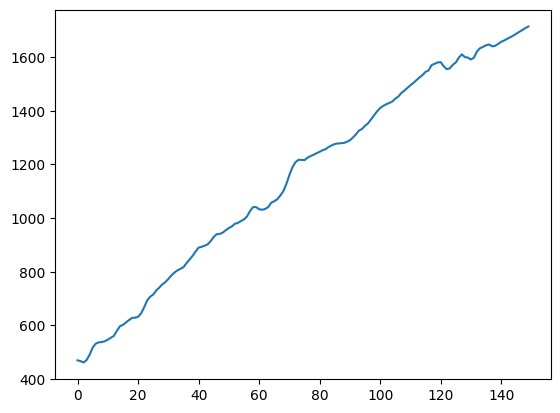

In [17]:
# 1d data
plt.plot(X_train[200])

In [ ]:
len(X_train[0][0][0])

11

In [ ]:
labels = load_gt(gt_data_path)

In [ ]:
X = []
for i in range(200):
  d1 = []
  for j in range(150):
    a = cv2.resize(X_train[i][j], (11, 11), interpolation=cv2.INTER_LINEAR)
    d1.append(a.astype(float))
  d1 = np.array(d1)
  X.append(d1)

In [ ]:

M = []
for i in range(200):
  d1 = []
  for j in range(150):
    uint = M_train[i][j].astype(np.uint8) * 255
    a = cv2.resize(uint, (11, 11), interpolation=cv2.INTER_AREA)
    d1.append(a)
  d1 = np.array(d1)
  M.append(d1)

In [ ]:
X = np.array(X)
M = np.array(M)

In [ ]:
X_train1 = X_train

In [ ]:
X_train = np.array(X_train)

In [ ]:
M_train = np.array(M_train)

In [ ]:
labels.shape

(500, 4)

In [ ]:
X1 = X * M

In [ ]:
np.max(X1)

884850.0

In [ ]:
X1 = X1 / 884850

In [ ]:
X_train = np.reshape(X_train, (600, 11, 11, 150))

In [ ]:
X_train.shape

(500, 11, 11, 150)

In [ ]:
for i in range(500):
  for j in range(11):
    for k in range(11):
      for l in range(150):
        if(M_train[i][j][k][l] == False):
          X_train[i][j][k][l] = 0

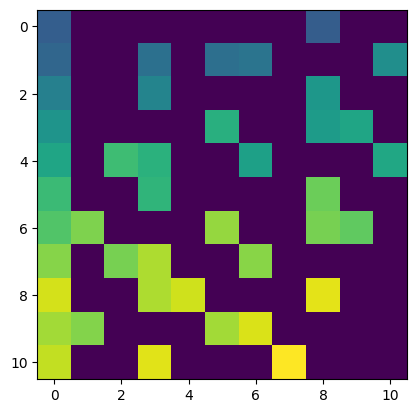

In [ ]:
plt.imshow(X_train[0,:,:,0])

2D CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32 , (1, 1), activation='relu', input_shape=(11, 11, 150)))
model.add(layers.AveragePooling2D((1, 1)))

model.add(layers.Conv2D(64 , (1, 1), activation='relu'))
model.add(layers.AveragePooling2D((1, 1)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='linear'))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
model.fit(X_train[:400], labels[:400], epochs=500, batch_size=8, validation_data=(X_train[400:500], labels[400:500]))

Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 446078.1875 - mae: 246.3151 - val_loss: 5713.1465 - val_mae: 54.1580
Epoch 2/500
50/50 [==============================] - 0s 8ms/step - loss: 2506.2881 - mae: 37.8234 - val_loss: 4697.9653 - val_mae: 48.0838
Epoch 3/500
50/50 [==============================] - 0s 7ms/step - loss: 2250.2466 - mae: 36.3061 - val_loss: 4161.3730 - val_mae: 41.0403
Epoch 4/500
50/50 [==============================] - 0s 6ms/step - loss: 1881.8643 - mae: 31.4220 - val_loss: 4266.6338 - val_mae: 43.4910
Epoch 5/500
50/50 [==============================] - 0s 7ms/step - loss: 2026.6941 - mae: 33.6048 - val_loss: 4135.5840 - val_mae: 42.7161
Epoch 6/500
50/50 [==============================] - 0s 7ms/step - loss: 1782.1323 - mae: 30.4291 - val_loss: 4304.5918 - val_mae: 41.2859
Epoch 7/500
50/50 [==============================] - 0s 7ms/step - loss: 1795.2758 - mae: 30.5837 - val_loss: 4170.8667 - val_mae: 42.1392
Epoch 8/500
50/50 [=====

In [ ]:
test_loss, test_mae = model.evaluate(X_train[500:], labels[500:])

4/4 [==============================] - 0s 4ms/step - loss: 3575.7744 - mae: 39.3244


In [ ]:
test_loss

3575.7744140625

2D CNN - LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32 , (3, 3), activation='relu', input_shape=(11, 11, 150)))
model.add(layers.AveragePooling2D((2, 2)))

model.add(layers.Conv2D(64 , (3, 3), activation='relu'))
model.add(layers.AveragePooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Reshape((1, -1)))
model.add(layers.LSTM(64, activation='relu'))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='linear'))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
model.fit(X_train[:400], labels[:400], epochs=50, batch_size=64, validation_data=(X_train[400:], labels[400:]))

In [ ]:
test_loss, test_mae = model.evaluate(X_train[400:], labels[400:])

4/4 [==============================] - 0s 8ms/step - loss: 4183.2939 - mae: 37.6149


In [ ]:
test_loss

4183.2939453125

3D CNN

In [1]:
from sklearn.preprocessing import MinMaxScaler

# Create MinMaxScaler instance
scaler = MinMaxScaler()

# Fit scaler to data and transform it
X_train1 = scaler.fit_transform(X_train)

In [ ]:
X_train3d = np.reshape(X_train, (600, 11, 11, 150, 1))

In [ ]:
X_train3d.shape

(600, 11, 11, 150, 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv3D(32, (1, 1, 2), activation='relu', input_shape=(11, 11, 150, 1)))
model.add(layers.AveragePooling3D((1, 1, 1)))

model.add(layers.Conv3D(64, (1, 1, 2), activation='relu'))
model.add(layers.AveragePooling3D((1, 1, 1)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print the model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 11, 11, 149, 32)   96        
                                                                 
 average_pooling3d_4 (Avera  (None, 11, 11, 149, 32)   0         
 gePooling3D)                                                    
                                                                 
 conv3d_5 (Conv3D)           (None, 11, 11, 148, 64)   4160      
                                                                 
 average_pooling3d_5 (Avera  (None, 11, 11, 148, 64)   0         
 gePooling3D)                                                    
                                                                 
 flatten_4 (Flatten)         (None, 1146112)           0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [2]:
model.fit(X_train3d[:400], labels[:400], epochs=100, batch_size=8, validation_data=(X_train3d[400:500], labels[400:500]))

In [ ]:
test_loss, test_mae = model.evaluate(X_train3d[500:600], labels[500:600])

In [ ]:
test_loss**0.5

26.34287999935004

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

masked_input = layers.Input(shape=(11, 11, 150, 1))
data_input = layers.Input(shape=(11, 11, 150, 1))

# Concatenate the input tensors along the channel dimension
combined_input = layers.Concatenate()([data_input, masked_input])
print(combined_input.shape)

# Define the model architecture
conv1 = layers.Conv3D(32, (1, 1, 50), activation='relu')(combined_input)
pool1 = layers.AveragePooling3D((1, 1, 1))(conv1)
conv2 = layers.Conv3D(64, (1, 1, 50), activation='relu')(pool1)
pool2 = layers.AveragePooling3D((1, 1, 1))(conv2)
flatten = layers.Flatten()(pool2)
dense1 = layers.Dense(64, activation='relu')(flatten)
output = layers.Dense(4, activation='linear')(dense1)

# Combine input and output layers to create the model
model = models.Model(inputs=[masked_input, data_input], outputs=output)

model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use appropriate loss function based on your task
              metrics=['mae'])

# Display model summary
model.summary()

# Train the model
history = model.fit([X_train1[:400], M_train1[:400]], labels[:400], epochs=100,
                    validation_data=([X_train1[400:], M_train1[400:] ], labels[400:]))


(None, 11, 11, 150, 2)
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 11, 11, 150, 1)]     0         []                            
                                                                                                  
 input_25 (InputLayer)       [(None, 11, 11, 150, 1)]     0         []                            
                                                                                                  
 concatenate_16 (Concatenat  (None, 11, 11, 150, 2)       0         ['input_26[0][0]',            
 e)                                                                  'input_25[0][0]']            
                                                                                                  
 conv3d_5 (Conv3D)           (None, 11, 11, 101, 32)      3232      

KeyboardInterrupt: 

In [ ]:
X_train1 = np.reshape(X_train, (500, 11, 11, 150, 1))
M_train1 = np.reshape(M_train, (500, 11, 11, 150, 1))

In [ ]:
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 11
SLICE_COUNT = 150

n_classes = 4
batch_size = 8

# x = tf.keras.Input(shape=(IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT), dtype=tf.float32)
# y = tf.keras.Input(shape=(n_classes,), dtype=tf.float32)

keep_rate = 0.9

In [ ]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [ ]:
tf.random.normal([64])

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 0.10115086, -1.945691  ,  0.40285757,  2.0383766 ,  0.9953945 ,
       -0.5809935 , -0.16286004,  0.40759248,  0.80625445,  0.9287159 ,
       -0.8120495 ,  0.4027626 ,  0.8993472 ,  0.35830373, -0.5414212 ,
       -0.32793972,  0.16521011,  0.9224293 ,  0.38775307,  0.15323867,
        0.55029154, -1.7037054 , -0.3455817 ,  0.58982235, -0.9495313 ,
       -1.9628018 ,  0.7868988 ,  0.41960946, -0.0120301 ,  0.7725604 ,
       -0.5845273 ,  0.5482695 ,  0.29339278, -0.03294135,  1.5558783 ,
       -0.59621173, -1.5498742 ,  1.9917103 ,  0.16328098,  0.4209951 ,
       -0.8351074 ,  1.0565029 ,  1.2185313 ,  1.5713726 ,  1.066861  ,
        0.6522824 ,  0.47756088,  1.8227777 , -1.1260029 , -1.4623476 ,
        0.52278   ,  0.09903459,  0.4662738 ,  0.09560031,  1.0857383 ,
       -1.564737  ,  1.1949328 , -1.2593824 ,  0.8328553 ,  1.3161554 ,
       -0.00966072,  1.0146114 ,  0.42456573,  0.2063071 ], dtype=float32)>

In [ ]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random.normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random.normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random.normal([21888,1024])),
               'out':tf.Variable(tf.random.normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random.normal([32])),
               'b_conv2':tf.Variable(tf.random.normal([64])),
               'b_fc':tf.Variable(tf.random.normal([1024])),
               'out':tf.Variable(tf.random.normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)

    print(conv1.shape)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    print(conv2.shape)

    fc = tf.reshape(conv2,[-1, 21888])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [ ]:
type(labels)
y = labels

In [ ]:
y.shape

(100, 4)

In [ ]:
X = tf.cast(X, tf.float32)

In [ ]:
X.dtype

tf.float32